# Implicit Richards’ Equation Solver using Picard iterative method (mixed form of RE)
**Governing equation (mixed‑form):**
$$
\frac{\partial \theta}{\partial t}
\;-\;\frac{\partial}{\partial z}\Bigl[K(\psi)\,\frac{\partial \psi}{\partial z}\Bigr]
\;-\;\frac{\partial K(\psi)}{\partial z}
\;=\;0
$$

- **ψ** = pressure head [cm]  
- **θ(ψ)** = volumetric water content [–]  
- **K(ψ)** = unsaturated hydraulic conductivity [cm/s]  

**Soil model:** van Genuchten–Mualem, parameters below.  
**Domain:** 10 m depth (Δz = 0.0125 m)  
**Time:** up to 0.18 days, test Δt = [0.01, 0.005, 0.002, 0.001] days  
**BCs:** top ponded ψ = 0.1 cm, bottom water table ψ = 0 m  
**IC:** ψ = –z initially (hydrostatic condition)

# INPUT SECTION

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

# ——— 1. DEFINE SOIL PARAMETERS ———
def setpars():
    """
    Return van Genuchten–Mualem soil parameters in a dictionary.
    All parameters are dimensionless or in consistent metric units:
      - Length in metres (m)
      - Time in days (d)
    """
    pars = {}
    pars['thetaR'] = 0.093      # residual water content [-]
    pars['thetaS'] = 0.301      # saturated water content [-]
    pars['alpha']  = 5.470      # inverse air-entry suction [1/m]
    pars['n']      = 4.264      # van Genuchten shape parameter n [-]
    pars['m']      = 0.76548    # van Genuchten shape parameter m = 1 - 1/n [-]
    pars['Ks']     = 5.040      # saturated hydraulic conductivity [m/day]
    pars['Ss']     = 1e-6       # specific storage [1/m] (used in mixed-form RE)
    return pars

# ——— 2. GRID & INITIAL/B.C. SETUP ———
def setup(dt):
    """
    Set up spatial and temporal grids, initial condition (IC),
    boundary conditions (BCs), and allocate the psi array.

    Parameters
    ----------
    dt : float
        Time step [days]

    Returns
    -------
    z : ndarray
        Spatial grid (node centres) [m]
    t : ndarray
        Temporal grid [days]
    dz : float
        Grid spacing [m]
    n : int
        Number of vertical nodes
    nt : int
        Number of time steps
    zN : float
        Total soil depth [m]
    psi : ndarray
        Pressure head array [nt × n] [m]
    psiB : float
        Bottom boundary head [m]
    psiT : float
        Top boundary head [m]
    pars : dict
        Dictionary of soil parameters
    """
    # Load soil parameters
    pars = setpars()

    # — Grid configuration —
    dz = 0.0125           # vertical resolution [m]
    zN = 10               # total depth of soil profile [m]
    z  = np.arange(dz, zN, dz)  # spatial grid (excluding z=0 surface)
    n  = len(z)           # number of spatial nodes

    # — Time configuration —
    tN = 0.18             # total simulation time [days]
    t  = np.arange(0, tN + dt, dt)  # temporal grid
    nt = len(t)           # number of time steps

    # — Allocate array for pressure head —
    psi = np.zeros((nt, n))       # psi[j, i] = pressure head at time j and node i

    # — Initial condition: hydrostatic equilibrium —
    psi[0, :] = -z                # ψ(z) = −z gives linear hydrostatic profile [m]

    # — Boundary conditions —
    psiT = 0.1                    # Top Dirichlet boundary: ponded head [m]
    psiB = 0.0                    # Bottom Dirichlet boundary: free drainage [m]

    return z, t, dz, n, nt, zN, psi, psiB, psiT, pars

# MODEL SET UP

In [ ]:
# ——— 3. DEPENDENT VARIABLES: C(ψ), K(ψ), θ(ψ) ———

def Cfun(psi, pars):
    """
    Specific moisture capacity C(ψ) = dθ/dψ.
    For ψ ≥ 0 (saturated), returns specific storage Ss;
    otherwise uses van Genuchten analytical derivative.
    """
    α, n, m = pars['alpha'], pars['n'], pars['m']
    θs, θr  = pars['thetaS'], pars['thetaR']
    Ss      = pars['Ss']

    x3 = 1 + (α * np.abs(psi))**n
    x2 = x3**(m + 1)
    x1 = α * n * m * (α * np.abs(psi))**(n - 1) / x2

    C = np.where(psi >= 0, Ss, (θs - θr) * x1)
    return C

def Kfun(psi, pars):
    """
    Hydraulic conductivity K(ψ) [m/day] using van Genuchten–Mualem model.
    Saturated conductivity Ks is used when ψ ≥ 0.
    """
    α, n, m, Ks = pars['alpha'], pars['n'], pars['m'], pars['Ks']

    x6 = 1 + (α * np.abs(psi))**n
    x5 = x6**(m * 0.5)
    x4 = (α * np.abs(psi))**(n - 1) * x6**(-m)
    x3 = 1 - x4
    x2 = x3**2
    x1 = x2 / x5

    K = np.where(psi >= 0, Ks, Ks * x1)
    return K

def thetafun(psi, pars):
    """
    Volumetric water content θ(ψ) [–] using the van Genuchten retention curve.
    For ψ ≥ 0, θ = θs (saturated condition).
    """
    α, n, m = pars['alpha'], pars['n'], pars['m']
    θs, θr  = pars['thetaS'], pars['thetaR']

    x3 = 1 + (α * np.abs(psi))**n
    x2 = x3**m
    x1 = (θs - θr) / x2

    theta = np.where(psi >= 0, θs, θr + x1)
    return theta


# ——— 4. LINEAR SOLVER: MIXED FORM (NON-SYMMETRIC A) ———

def solverfun(R, C, Kmid, dt, dz, n):
    """
    Solve the linear system A·Δψ = R using a tridiagonal matrix A,
    assembled from mixed-form finite-volume discretisation.
    This version includes both storage and flux terms.
    """
    # Allocate diagonals and RHS
    a = Kmid[:-1] / dz
    b = -(Kmid[:-1] + Kmid[1:]) / dz - C * dz / dt
    c = Kmid[1:] / dz

    # Assemble tridiagonal matrix
    A = np.diag(a[1:], -1) + np.diag(b, 0) + np.diag(c[:-1], 1)

    # Solve A·Δψ = R
    dell = np.linalg.solve(A, R)
    return dell

# ——— 5. RESIDUAL FUNCTION: MIXED-FORM R(ψ) ———

def Rfun(psiiter, psiin, psiT, psiB, C, Kmid, dtheta, dt, dz, n):
    """
    Compute the residual R(ψ^m) for current Picard iteration (mixed form).
    Includes:
      - Accumulation term: dθ/dt
      - Flux divergence term using K·∂ψ/∂z
    """
    psigrid = np.hstack((psiB, psiiter, psiT))  # include boundary heads

    # Term-by-term residual construction
    x1 = dtheta / dt * dz                           # accumulation
    x2 = -(Kmid[1:] - Kmid[:-1])                    # ∂K/∂z (gravity)
    x3 = -Kmid[1:] * (psigrid[2:] - psigrid[1:-1]) / dz  # top flux
    x4 = +Kmid[:-1] * (psigrid[1:-1] - psigrid[:-2]) / dz  # bottom flux

    R = x1 + x2 + x3 + x4
    return R

# ——— 6. PICARD ITERATION LOOP: MIXED FORM ———

def iterfun(psiin, pars, psiT, psiB, dt, dz, n):
    """
    Perform one time step update using Picard iteration (mixed form).
    The time derivative uses θ(ψ), but ψ is the updated unknown.
    """
    tolerance = 1e-10
    maxcount  = 1000

    # Initial guess: ψ^n+1,0 = ψ^n
    psiiter = psiin.copy()
    psiout  = np.zeros_like(psiin)

    count = 0
    while count <= maxcount:
        # Evaluate storage, conductivity, and moisture change
        C      = Cfun(psiiter, pars)
        Kfull  = Kfun(np.hstack((psiB, psiiter, psiT)), pars)
        Kmid   = 0.5 * (Kfull[1:] + Kfull[:-1])
        dtheta = thetafun(psiiter, pars) - thetafun(psiin, pars)

        # Compute residual and solve for Δψ
        R    = Rfun(psiiter, psiin, psiT, psiB, C, Kmid, dtheta, dt, dz, n)
        dell = solverfun(R, C, Kmid, dt, dz, n)

        # Update ψ
        psiout = psiiter + dell
        psiiter = psiout.copy()

        # Convergence check
        if np.max(np.abs(R)) < tolerance:
            break

        count += 1

    return psiout

# ——— 7. MASS BALANCE CHECK ———

def massbal(psi, psiT, psiB, pars, n, dt, dz):
    """
    Compute cumulative mass balance: change in storage vs. net inflow.
    Mixed form uses θ(ψ) to compute storage at each time step.
    """
    # θ(ψ) reshaped to match ψ structure
    theta = thetafun(psi.reshape(-1), pars)
    theta = theta.reshape(psi.shape)
    S = np.sum(theta * dz, axis=1)
    S0, SN = S[0], S[-1]

    # Inflow (top boundary flux)
    Kin = 0.5 * (Kfun(psiB, pars) + Kfun(psi[:, 0], pars))
    QIN = -Kin * ((psi[:, 0] - psiB) / dz + 1.0)
    QIN[0] = 0.0
    QINsum = np.sum(QIN) * dt

    # Outflow (bottom boundary flux)
    Kout = 0.5 * (Kfun(psi[:, -1], pars) + Kfun(psiT, pars))
    QOUT = -Kout * ((psiT - psi[:, -1]) / dz + 1.0)
    QOUT[0] = 0.0
    QOUTsum = np.sum(QOUT) * dt

    # Total storage change vs. net flux
    dS = SN - S0
    dQ = QINsum - QOUTsum
    err = dS / dQ

    return QIN, QOUT, S, err

# ——— 8. MODEL EXECUTION ———

def ModelRun(dt, dz, n, nt, psi, psiB, psiT, pars):
    """
    Advance the mixed-form Richards equation in time using Picard iteration.
    Returns pressure head solution and diagnostic mass balance data.
    """
    for j in range(1, nt):
        psi[j, :] = iterfun(psi[j-1, :], pars, psiT, psiB, dt, dz, n)

    QIN, QOUT, S, err = massbal(psi, psiT, psiB, pars, n, dt, dz)
    return psi, QIN, QOUT, S, err

# SIMULATION RUN

Simulation time for dt = 0.01 s: 405.4174120426178 seconds
Simulation time for dt = 0.005 s: 813.9649047851562 seconds
Simulation time for dt = 0.002 s: 630.358959197998 seconds
Simulation time for dt = 0.001 s: 439.12197256088257 seconds


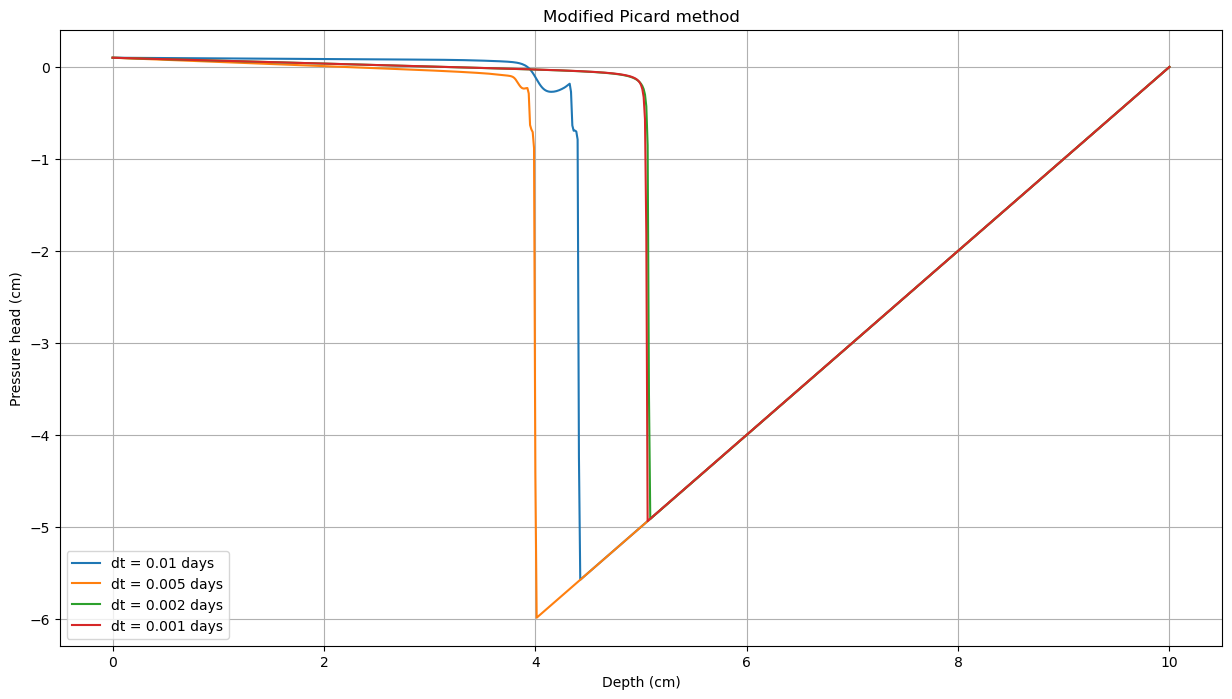

In [ ]:
# ——— 9. RUN & PLOT ———

dt=np.array([0.01, 0.005, 0.002, 0.001]) # Define different dt values
err_values = []

psi_results = {} # Initialize a dictionary to store psi values for each dti

plt.figure(figsize=(15, 8))

for dti in dt:
    z,t,dz,n,nt,zN,psi,psiB,psiT,pars=setup(dti)

    start_time = time.time()  # Record the start time

    psi,QIN,QOUT,S,err=ModelRun(dti,dz,n,nt,psi,psiB,psiT,pars)

    # Record the end time
    end_time = time.time()

    z=np.hstack([0,z,zN])
    z=z[-1]-z
    psi=np.hstack([psiB,psi[-1,:],psiT]) # Solve for pressure head (psi)
    theta_fin = thetafun(psi,pars) # Solve for moisture content (theta)
    K_fin = Kfun(psi,pars) # Solve for hydraulic conductivity (K)

    psi_results[dti] = psi # Store psi values in the dictionary

    psi_plot = plt.plot(z, psi, label=f'dt = {dti} days') # Plot z vs psi for each dti

    # Calculate and print the simulation time for each dti
    sim_time = end_time - start_time
    print(f"Simulation time for dt = {dti} s: {sim_time} seconds")

    # Append the err value for the current dt to the list
    err_values.append(err)

# Convert the list of err values to a numpy array for easy plotting
err_values = np.array(err_values)

plt.xlabel('Depth (cm)')
plt.ylabel('Pressure head (cm)')
plt.title('Modified Picard method')
plt.legend()  # Show legend with dti values
plt.grid(True)
plt.show()

# PSI RESULTS FOR DIFFERENT TIME STEPS (dt)

In [ ]:
# ——— 10. COMPARISON OF RESULTS FOR DIFFERENT TIME-STEP ———

df_psi = pd.DataFrame(psi_results) # Convert psi_results to DataFrame

# Add the 'z' values as the first column
df_psi.insert(0, 'Depth (m)', z)
df_psi = df_psi.iloc[::-1]

# Save DataFrame as a string and write to an Excel file
excel_file = r"Modified_Picard_results.xlsx" # Specify the name where you want to save the Excel file
df_psi.to_excel(excel_file, index=False) # Export the DataFrame to an Excel file

# RESULTS FOR ALL VARIABLES (psi, theta and K) AT LAST DEFINED TIME STEP (dt)

In [ ]:
# ——— 11. OUTPUT TABLE ———

z_df = pd.DataFrame({'Depth (m)': z}) # Convert arrays to dataframes
z_df = z_df.iloc[::-1]
psi_df = pd.DataFrame({'Head (m)': psi})
theta_df = pd.DataFrame({'Moisture content)': theta_fin})
K_df = pd.DataFrame({'Conductivity (m/d)': K_fin})

# Concatenate dataframes along columns
results_df = pd.concat([z_df, psi_df, theta_df, K_df], axis=1)

# Display the dataframe
print(results_df)

     Depth (m)  Head (m)  Moisture content)  Conductivity (m/d)
800     0.0000  0.100000           0.301000            5.040000
799     0.0125  0.099603           0.301000            5.040000
798     0.0250  0.099205           0.301000            5.040000
797     0.0375  0.098808           0.301000            5.040000
796     0.0500  0.098410           0.301000            5.040000
..         ...       ...                ...                 ...
4       9.9500 -0.050000           0.300370            4.887627
3       9.9625 -0.037500           0.300815            4.980728
2       9.9750 -0.025000           0.300967            5.024371
1       9.9875 -0.012500           0.300998            5.038392
0      10.0000  0.000000           0.301000            5.040000

[801 rows x 4 columns]


# MASS BALANCE SIMULATION

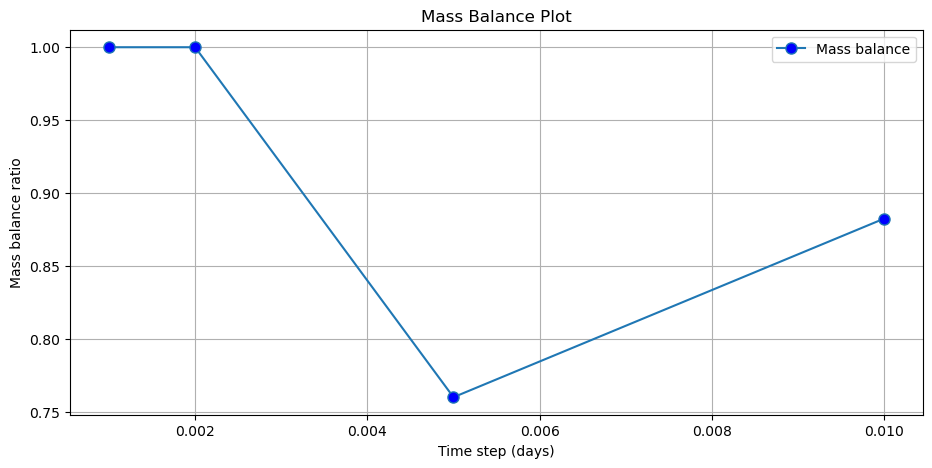

In [ ]:
# ——— 12. MASS BALANCE PLOT ———

reference_value = 1.0  # Reference value to compare with

# Set a tolerance level for equality
tolerance = 1e-6  # Define the tolerance level here

# Applying the condition to modify err_values
condition = np.isclose(err_values, reference_value, atol=tolerance)
err_values_modified = np.where(condition, reference_value, err_values)

# Plotting err against dt
plt.figure(figsize=(11, 5))
plt.plot(dt, err_values_modified, 'o-', label='Mass balance', markerfacecolor='blue', markersize=8)
plt.xlabel('Time step (days)')
plt.ylabel('Mass balance ratio')
plt.title('Mass Balance Plot')
plt.legend()
plt.grid(True)
plt.show()